In [65]:
import numpy as np
import csv
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [66]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Настройка выходного конвеера

In [79]:
messages = pd.read_csv("messages.csv", encoding="utf-8")
messages = messages[["id", "text"]]
messages.head()


labels = pd.read_csv("labels.csv", encoding="utf-8")
labels = labels[["id","label"]]
# labels['label'] = labels['label'].map({'other': 0, 'task': 1, 'event':3})
labels.head()
messages["label"] = labels["label"].values

dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
# print(dataset["test"])
train_dataset = tf.data.Dataset.from_tensor_slices(messages)
# train_dataset, test_dataset = ds[2000:], ds[:2000]
# print(type(train_dataset))
train_dataset.element_spec

for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [75]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset.element_spec



2023-05-21 23:23:16.065017: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6365]
	 [[{{node Placeholder/_0}}]]
2023-05-21 23:23:16.065257: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6365]
	 [[{{node Placeholder/_0}}]]


AttributeError: 'str' object has no attribute 'numpy'

Создание кодировщика текста

In [59]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
print(messages)
encoder.adapt(train_dataset.map())

        id                                               text  label
0     2092   насколько я понимаю всем рекомендашкам нужны ...  other
1     8104  ну странно что итмо об этом не думает хотя эти...  other
2     5821  мы просто пока ограничимся питером допустим и ...  other
3     8030  добавил названия таблиц текст сообщения в этой...  other
4     6966                                             готово  other
...    ...                                                ...    ...
8360  6371                                         че сидите   other
8361  2810  а то забыл скинуть после того как остановил па...  other
8362  1760  на паре файлов прям нормально сработало на нек...  other
8363  2547                                       захожу в зум  other
8364  3804  принято за эту неделю точно доделаю личность и...  other

[8365 rows x 3 columns]


TypeError: in user code:


    TypeError: outer_factory.<locals>.inner_factory.<locals>.<lambda>() missing 1 required positional argument: 'labels'


In [47]:
vocab = np.array(encoder.get_vocabulary())
print(len(vocab))

2


Модель

In [60]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=2,
        output_dim=1000,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Оцениваем предложения

In [61]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

2023-05-21 23:06:32.679316: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at lookup_table_op.cc:929 : FAILED_PRECONDITION: Table not initialized.
2023-05-21 23:06:32.679335: I tensorflow/core/common_runtime/executor.cc:1210] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): FAILED_PRECONDITION: Table not initialized.
	 [[{{node sequential_3/text_vectorization_17/string_lookup_17/None_Lookup/LookupTableFindV2}}]]


FailedPreconditionError: Graph execution error:

Detected at node 'sequential_3/text_vectorization_17/string_lookup_17/None_Lookup/LookupTableFindV2' defined at (most recent call last):
    File "/opt/homebrew/Cellar/python@3.10/3.10.11/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Cellar/python@3.10/3.10.11/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Cellar/python@3.10/3.10.11/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/homebrew/Cellar/python@3.10/3.10.11/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/homebrew/Cellar/python@3.10/3.10.11/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/gt/1p56k6_953vf4ry2gk6kzwmr0000gp/T/ipykernel_84943/2610194791.py", line 5, in <module>
      predictions = model.predict(np.array([sample_text]))
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2283, in predict_step
      return self(x, training=False)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 404, in call
      return super().call(inputs, training=training, mask=mask)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/layers/preprocessing/text_vectorization.py", line 632, in call
      lookup_data = self._lookup_layer(inputs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/layers/preprocessing/index_lookup.py", line 754, in call
      lookups = tf.ragged.map_flat_values(self._lookup_dense, inputs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/layers/preprocessing/index_lookup.py", line 792, in _lookup_dense
      lookups = self.lookup_table.lookup(inputs)
Node: 'sequential_3/text_vectorization_17/string_lookup_17/None_Lookup/LookupTableFindV2'
Table not initialized.
	 [[{{node sequential_3/text_vectorization_17/string_lookup_17/None_Lookup/LookupTableFindV2}}]] [Op:__inference_predict_function_25496]

In [62]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

2023-05-21 23:06:50.313804: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at lookup_table_op.cc:929 : FAILED_PRECONDITION: Table not initialized.
2023-05-21 23:06:50.313827: I tensorflow/core/common_runtime/executor.cc:1210] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): FAILED_PRECONDITION: Table not initialized.
	 [[{{node sequential_3/text_vectorization_17/string_lookup_17/None_Lookup/LookupTableFindV2}}]]


FailedPreconditionError: Graph execution error:

Detected at node 'sequential_3/text_vectorization_17/string_lookup_17/None_Lookup/LookupTableFindV2' defined at (most recent call last):
    File "/opt/homebrew/Cellar/python@3.10/3.10.11/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Cellar/python@3.10/3.10.11/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Cellar/python@3.10/3.10.11/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/homebrew/Cellar/python@3.10/3.10.11/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/homebrew/Cellar/python@3.10/3.10.11/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/gt/1p56k6_953vf4ry2gk6kzwmr0000gp/T/ipykernel_84943/2610194791.py", line 5, in <module>
      predictions = model.predict(np.array([sample_text]))
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2283, in predict_step
      return self(x, training=False)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 404, in call
      return super().call(inputs, training=training, mask=mask)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/layers/preprocessing/text_vectorization.py", line 632, in call
      lookup_data = self._lookup_layer(inputs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/layers/preprocessing/index_lookup.py", line 754, in call
      lookups = tf.ragged.map_flat_values(self._lookup_dense, inputs)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/layers/preprocessing/index_lookup.py", line 792, in _lookup_dense
      lookups = self.lookup_table.lookup(inputs)
Node: 'sequential_3/text_vectorization_17/string_lookup_17/None_Lookup/LookupTableFindV2'
Table not initialized.
	 [[{{node sequential_3/text_vectorization_17/string_lookup_17/None_Lookup/LookupTableFindV2}}]] [Op:__inference_predict_function_25496]

In [63]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [81]:
history = model.fit(messages["text"], epochs=3,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/3


ValueError: in user code:

    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1082, in train_step
        self._validate_target_and_loss(y, loss)
    File "/Users/taranyuriy/Projects/ml/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1036, in _validate_target_and_loss
        raise ValueError(

    ValueError: Target data is missing. Your model was compiled with loss=<keras.src.losses.BinaryCrossentropy object at 0x2c3d89ed0>, and therefore expects target data to be provided in `fit()`.


In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 51s 129ms/step - loss: 0.3160 - accuracy: 0.8554
Test Loss: 0.3160427510738373
Test Accuracy: 0.8554400205612183


(0.0, 0.6594359248876571)

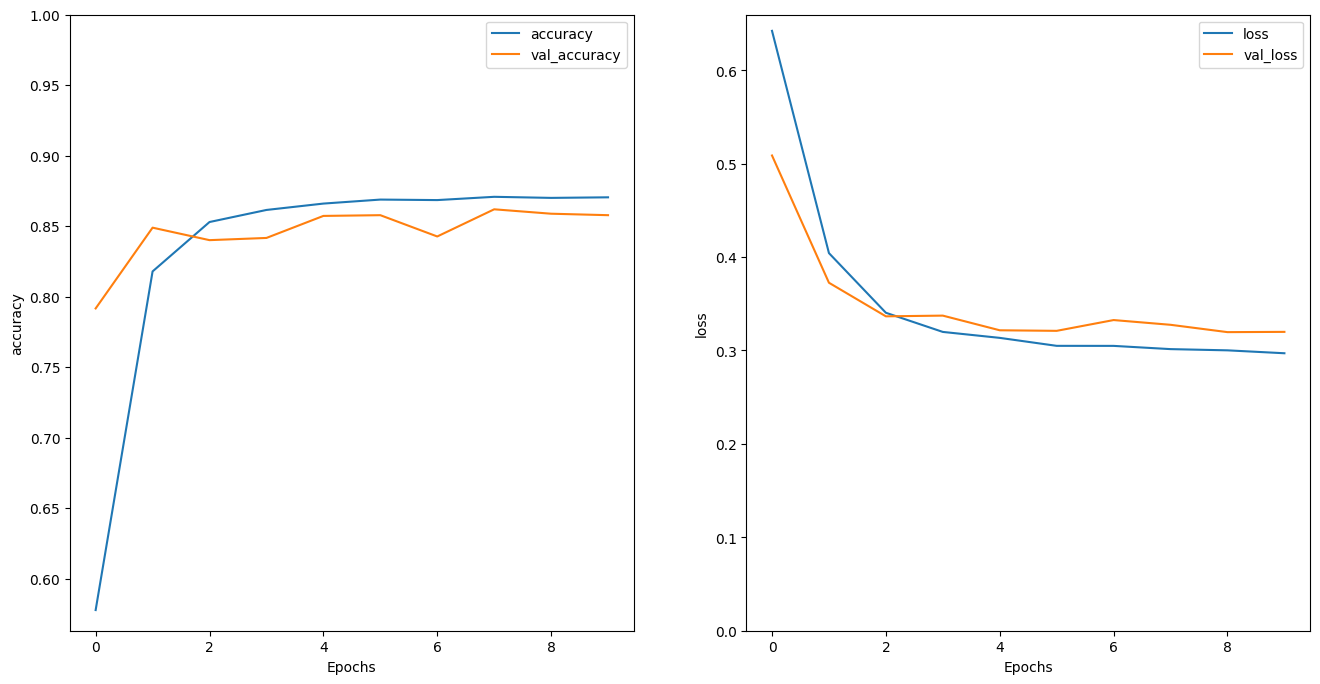

In [27]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [28]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [30]:
history = model.fit(train_dataset, epochs=3,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/3
391/391 [==============================] - 603s 2s/step - loss: 0.6459 - accuracy: 0.5613 - val_loss: 0.4771 - val_accuracy: 0.7688
Epoch 2/3
391/391 [==============================] - 604s 2s/step - loss: 0.4032 - accuracy: 0.8249 - val_loss: 0.3498 - val_accuracy: 0.8490
Epoch 3/3
391/391 [==============================] - 373s 954ms/step - loss: 0.3436 - accuracy: 0.8525 - val_loss: 0.3366 - val_accuracy: 0.8562


In [31]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 90s 229ms/step - loss: 0.3280 - accuracy: 0.8604
Test Loss: 0.3279775083065033
Test Accuracy: 0.8604400157928467


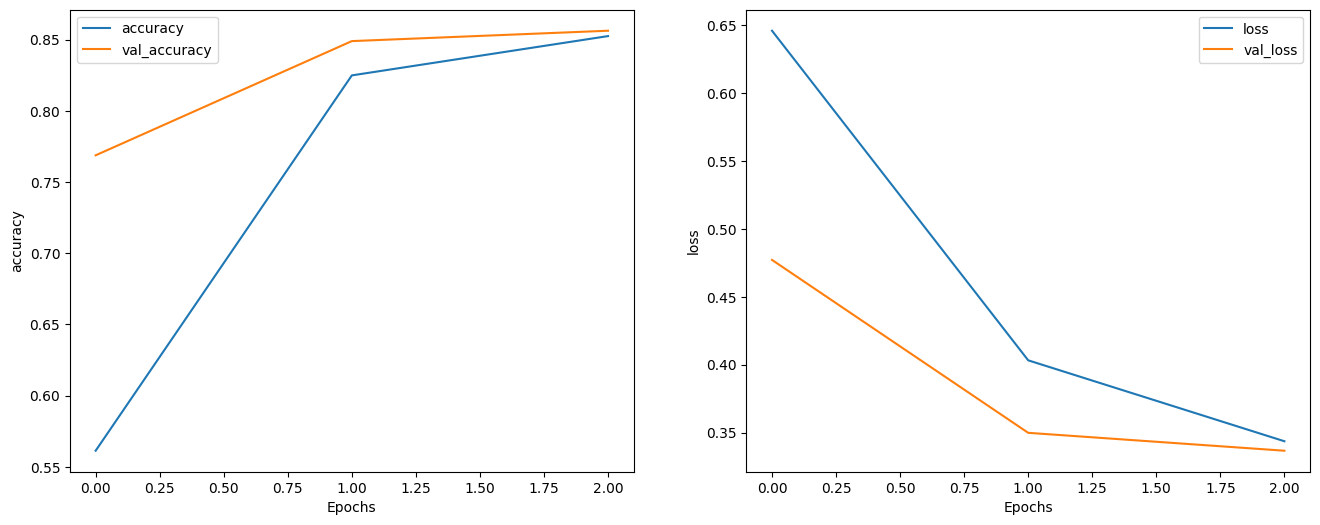

In [32]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')